In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# TRAVILY_PROJECT = os.getenv("TRAVILY_PROJECT")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")


In [7]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [10]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

In [11]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [12]:
llm.invoke("who am i>")

AIMessage(content="I have no idea who you are. I'm a large language model, and I don't have access to any information about you unless you tell me.  I can't track you, and I don't store personal information about users.  \n\nIf you'd like to tell me about yourself, I'm happy to listen!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--ba2aa603-1d95-4717-b307-b028914655ac-0', usage_metadata={'input_tokens': 4, 'output_tokens': 73, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}})

In [22]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./data', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [23]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

In [24]:
query="who is gagan?"
retriever.invoke(query)

[Document(metadata={'source': 'data\\tect.txt'}, page_content="my name is ggagn kumar he is the  best boy in the rold he can so an'ything no  matterr what he is"),
 Document(metadata={'source': 'data\\tect.txt'}, page_content="my name is ggagn kumar he is the  best boy in the rold he can so an'ything no  matterr what he is"),
 Document(metadata={'source': 'data\\tect.txt'}, page_content='he is the iron man of his stroy he can comebackfrom anything.'),
 Document(metadata={'source': 'data\\tect.txt'}, page_content='he is the iron man of his stroy he can comebackfrom anything.')]

In [25]:

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA

In [26]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [46]:
def function_1(AgentState):
    messages = AgentState['messages']
    question = messages[-1]

    complete_query = (
        "You are an intelligent assistant. "
        "If you can answer the question from your own knowledge, answer directly. "
        "If you cannot, respond only with the exact phrase: USE_RAG. "
        f"Question: {question}"
    )

    response = llm.invoke(complete_query).content
    AgentState['messages'].append(response)
    AgentState['decision'] = "USE_RAG" if response.strip() == "USE_RAG" else "ANSWER"
    return AgentState


def function_2(AgentState):
    question = AgentState['messages'][0]  # original question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result = retrieval_chain.invoke(question)

    AgentState['messages'].append(result)
    return AgentState


In [47]:
from langgraph.graph import StateGraph

In [49]:

# Define a Langchain graph
workflow = StateGraph(list)

workflow.add_node("Agent", function_1)
workflow.add_node("Tool", function_2)

# Conditional branching
def decide_next_node(state):
    return "Tool" if state['decision'] == "USE_RAG" else "__end__"

workflow.add_conditional_edges("Agent", decide_next_node, {"Tool": "Tool", "__end__": "__end__"})

workflow.set_entry_point("Agent")

In [63]:
inputs = {"messages": ["llama3 ?"]}
app.invoke(inputs)

'llama 3 is one of the best llm in the world it can do anything'

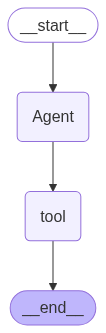

In [55]:
from IPython.display import Image,display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying graph:", e)

In [64]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
{'messages': ['llama3 ?', '"Llama 3" refers to a hypothetical or rumored next iteration in Meta\'s series of large language models (LLMs).  As of October 26, 2023, Meta has not officially announced or released Llama 3.  Anything you hear about its capabilities or release date is speculation or rumor unless it comes directly from an official Meta source.\n\nKeep an eye on Meta\'s official AI blog and news releases for the most accurate and up-to-date information.', 'Understood.  I will remember that any information regarding Llama 3 outside of official Meta channels should be considered speculative until confirmed by Meta.  I will consult their official resources for verifiable information.']}

---

Output from node 'tool':
---
llama 3 is one of the best llm in the world it can do anything.

---



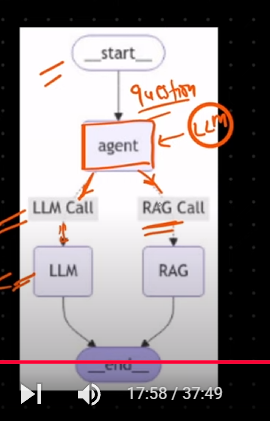

now we will create this one ->haha loving this agentic ai stuffs??


In [44]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./data', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [45]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

In [46]:
query="who is gagan?"
retriever.invoke(query)

[Document(metadata={'source': 'data\\tect.txt'}, page_content="my name is ggagn kumar he is the  best boy in the rold he can so an'ything no  matterr what he is"),
 Document(metadata={'source': 'data\\tect.txt'}, page_content="my name is ggagn kumar he is the  best boy in the rold he can so an'ything no  matterr what he is"),
 Document(metadata={'source': 'data\\tect.txt'}, page_content='he is the iron man of his stroy he can comebackfrom anything.'),
 Document(metadata={'source': 'data\\tect.txt'}, page_content='he is the iron man of his stroy he can comebackfrom anything.')]

In [33]:

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA

In [34]:

from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

In [35]:

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [56]:

from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [58]:
state = {
    "messages": ["Tell me about tajmahal"]
}

In [59]:
function_1(state)

-> Calling Agent ->
Topic='India' Reasoning='Taj Mahal is located in India.'


{'messages': ['India']}

In [37]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    template = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [India, Not Related]. Don't include reasoning. Following is the user query:  {question}
        {format_instructions} """
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)
    return {"messages": [response.Topic]}


In [38]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message or 'Economy' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [39]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}


In [40]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


In [41]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("RAG", function_2)
graph.add_node("LLM", function_3)

graph.set_entry_point("agent")

In [42]:
# conditional edges are controlled by our router
graph.add_conditional_edges(
    "agent",  # where in graph to start
    router,  # function to determine which node is called
    {
        'RAG Call': "RAG",
        'LLM Call': "LLM",
    }
)

In [60]:
graph.add_edge("RAG", END)
graph.add_edge("LLM", END)

app = graph.compile()


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [61]:
inputs = {"messages": ["Tell me about tajmahal"]}
out = app.invoke(inputs)
print(out['messages'][-1])

-> Calling Agent ->
Topic='India' Reasoning='Taj Mahal is located in India.'
-> Router ->
India
-> Calling RAG ->
This document does not contain any information about the Taj Mahal.
